# Model assessment: LOO-CV for factory data with Stan


If this is to be executed, please execute the source code at the end of the report first. The report addresses the first two points of the assignment for each model, then give conlusion on the differences between models.

## SEPARATE MODEL


**psis-loo, p_eff, k-values**

PSIS-LOO value is -131.99480704408487
p_eff value is 9.448912107852621
Histogram of k-values:
[0.3038364  0.23812124 0.5374844  0.23812041 0.20129228 0.56844808
 0.29584671 0.21251372 0.56875015 0.28014507 0.16548769 0.23660643
 0.29584671 0.16288348 0.56427522 0.2231835  0.50419384 0.25184175
 0.74372511 0.18239086 0.56194547 0.48764583 0.20129228 0.20851127
 0.31580757 0.82513724 0.68571975 0.2231835  0.14346505 0.26028729]


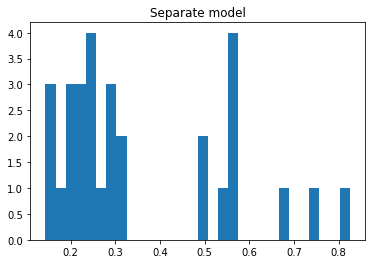

In [5]:
get_separate_result()

**Assement based on k-values**

As can be seen from the histogram, there are **several k-values** > 0.7 , which is still very small w.r.t the number of samples. Then PSIS-LOO is considered **reliable** in this case



## POOL MODEL


**psis-loo, p_eff, k-values**

PSIS-LOO value is -130.870493652447
p_eff value is 1.9393666740129447
Histogram of k-values:
[-0.00709425  0.09247539 -0.05578389 -0.0408335  -0.00298315  0.17840998
  0.01186253  0.01519206 -0.01127108  0.10715439 -0.03972638  0.01186253
  0.01186253  0.07776282  0.01186253  0.0725519  -0.05927501 -0.0605868
  0.38399115 -0.0605868  -0.00274862 -0.06706608 -0.00298315 -0.01307678
  0.01828661 -0.00653085  0.01828661  0.0725519   0.01186253 -0.04578775]


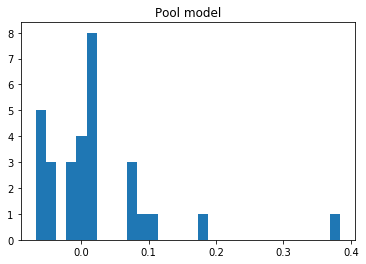

In [6]:
get_pool_result()

**Assement based on k-values**

As can be seen from the histogram, **all k-values < 0.7** (in fact all k-values are less than ~ 0.5). Then PSIS-LOO is considered **very reliable** in this case



## HIERARCHICAL MODEL

**psis-loo, p_eff, k-values**

PSIS-LOO value is -126.82855592407277
p_eff value is 5.718071974593229
Histogram of k-values:
[0.21865567 0.18714982 0.2515771  0.22397118 0.31322165 0.56056021
 0.32520664 0.14011357 0.17734538 0.15096168 0.28810053 0.22996009
 0.32520664 0.1628182  0.11675038 0.11680415 0.35011573 0.33354877
 0.57583521 0.06257218 0.11600024 0.29372378 0.31322165 0.20355533
 0.14294187 0.32822864 0.39697264 0.11680415 0.17163832 0.25442584]


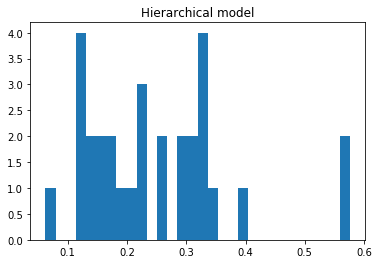

In [7]:
get_hierarchical_result()

**Assement based on k-values**

From the histogram, **all k-values < 0.7**. Then PSIS-LOO is considered **reliable** in this case



-------------------------------

##  CONCLUSION ON DIFFERENCE BETWEEN MODELS

All models are reliable even with different distribution of k-values. If we consider towards model with best predictive accuracy, then **HIERARCHICAL MODEL** should be selected, because its PSIS-LOO value is the highest (or the sum of log predictive density is the highest)

 
-------------------------------

**SOURCE CODE**  

Some bootstraping code and common function

In [4]:
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt
from psis import psisloo

np.random.seed(seed=123)
raw_data = np.loadtxt('factory.txt')
data = dict(N=5, K=6, y=raw_data)

def get_p_eff(log_lik, lppd_loocv):    
    likelihoods = np.asarray([np.exp(log_likelihood.flatten()) for log_likelihood in log_lik])
    num_sim, num_obs = likelihoods.shape
    lppd = 0
    for obs in range(num_obs):
        lppd += np.log(np.sum(likelihoods[:, obs]) / num_sim)
    
    p_eff = lppd - lppd_loocv
    return p_eff
    
def extract_result_from_fit(samples, plot_title=''):
    log_lik_matrix = np.asarray([single_sample.flatten() for single_sample in samples['log_lik']])
    loo, loos, ks = psisloo(log_lik_matrix)

    # Calculate p_eff
    p_eff = get_p_eff(log_lik_matrix, loo)

    print(f'PSIS-LOO value is {loo}')
    print(f'p_eff value is {p_eff}')
    print('Histogram of k-values:')
    print(ks)
    plt.hist(ks, 30)
    plt.title(plot_title)
    plt.show()
    
    

Model codes. From top to bottom: separate, pool, hierarchical

In [3]:
%%capture
separate_model = """
data {
  int<lower=0> N; // number of observations per machine
  int<lower=0> K; // number of machines
  matrix[N,K] y; // N * K matrix of observation
}
parameters {
  real theta[K]; // group means
  real<lower=0> sigma[K]; // group std
}
model {
  for (k in 1:K)
    y[:,k] ~ normal(theta[k], sigma[k]);
}
generated quantities {
    matrix[N,K] log_lik;
    for (k in 1:K)
      for (i in 1:N)
        log_lik[i,k] = normal_lpdf(y[i,k] | theta[k], sigma[k]);
}
"""

separate_sm = pystan.StanModel(model_code=separate_model)
separate_fit = separate_sm.sampling(data=data, iter=2000, chains=4)

pool_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N,K] y;
}
parameters {
  real theta; // common mean
  real sigma; // common std
}
model {
  for (k in 1:K)
    y[:,k] ~ normal(theta, sigma);
}
generated quantities {
    matrix[N,K] log_lik;
    for (k in 1:K)
      for (i in 1:N)
        log_lik[i,k] = normal_lpdf(y[i,k] | theta, sigma);
}
"""

pool_sm = pystan.StanModel(model_code=pool_model)
pool_fit = pool_sm.sampling(data=data, iter=2000, chains=4)

hierarchical_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N,K] y;
}
parameters {
  real theta0; // common theta for each K machine theta
  real<lower=0> sigma0; // machine specific sigma
  real theta[K]; // machine specific theta
  real<lower=0> sigma; // common std
}
model {
  for (k in 1:K)
    theta[k] ~ normal(theta0, sigma0);
  for (k in 1:K)
    y[:,k] ~ normal(theta[k], sigma);
}
generated quantities {
    matrix[N,K] log_lik;
    for (k in 1:K)
      for (i in 1:N)
        log_lik[i,k] = normal_lpdf(y[i,k] | theta[k], sigma);
}
"""

hierarchical_sm = pystan.StanModel(model_code=hierarchical_model)
hierarchical_fit = hierarchical_sm.sampling(data=data, iter=2000, chains=4)


def get_separate_result():
    extract_result_from_fit(separate_fit, 'Separate model')    
    
def get_pool_result():
    extract_result_from_fit(pool_fit, 'Pool model')    
    
def get_hierarchical_result():
    extract_result_from_fit(hierarchical_fit, 'Hierarchical model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9247cbd108702a6c1e62d7d5ffdd0aa NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3b1d4093fb7ad91b3fc12139a8e74a9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_431a2067d773445b37801edf625af93b NOW.
